In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
train = pd.read_csv("/gdrive/My Drive/Data/train.csv")

In [6]:
train.head().T

,0,1,2,3,4
user_name,NaN,@wawinereport,NaN,@vossroger,@vossroger
country,Australia,US,Italy,France,France
review_title,Andrew Peace 2007 Peace Family Vineyard Chardo...,North by Northwest 2014 Red (Columbia Valley (...,Renato Ratti 2007 Conca (Barolo),Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...
review_description,"Classic Chardonnay aromas of apple, pear and h...",This wine is near equal parts Syrah and Merlot...,Barolo Conca opens with inky dark concentratio...,It's impressive what a small addition of Sauvi...,"This ripe, sweet wine is rich and full of drie..."
designation,Peace Family Vineyard,NaN,Conca,L'Abbaye,Le Cèdre Vintage
points,83,89,94,87,88
price,10,15,80,22,33
province,Australia Other,Washington,Piedmont,Southwest France,France Other
region_1,South Eastern Australia,Columbia Valley (WA),Barolo,Bergerac Sec,Vin de Liqueur
region_2,NaN,Columbia Valley,NaN,NaN,NaN


In [7]:
train['variety'].unique().shape[0]

28

In [8]:
# Create a new dataframe with two columns
df2 = train[['variety', 'review_description','price','points']].copy()

# Remove missing values (NaN)

df2= df2[pd.notnull(df2['review_description'])]
df2= df2[pd.notnull(df2['price'])]
df2= df2[pd.notnull(df2['points'])]

# Renaming second column for a simpler name

df2.columns = ['variety', 'review','price','points']
df2.shape

(77088, 4)

In [0]:
total = df2['review'].notnull().sum()

In [10]:
pd.DataFrame(train['variety'].unique()).values

array([['Chardonnay'],
       ['Red Blend'],
       ['Nebbiolo'],
       ['Bordeaux-style White Blend'],
       ['Malbec'],
       ['Cabernet Sauvignon'],
       ['Zinfandel'],
       ['Pinot Noir'],
       ['Sauvignon Blanc'],
       ['Gamay'],
       ['Grüner Veltliner'],
       ['Bordeaux-style Red Blend'],
       ['Sangiovese'],
       ['Syrah'],
       ['White Blend'],
       ['Cabernet Franc'],
       ['Portuguese Red'],
       ['Portuguese White'],
       ['Rhône-style Red Blend'],
       ['Rosé'],
       ['Champagne Blend'],
       ['Merlot'],
       ['Riesling'],
       ['Sparkling Blend'],
       ['Pinot Grigio'],
       ['Tempranillo'],
       ['Pinot Gris'],
       ['Gewürztraminer']], dtype=object)

In [0]:
df2 = df2.sample(10000, random_state=1).copy()

In [12]:
# Create a new column 'category_id' with encoded categories 
df2['catid'] = df2['variety'].factorize()[0]
catid_df2 = df2[['variety', 'catid']].drop_duplicates()

# Dictionaries for future use
catid2 = dict(catid_df2.values)
idcat2 = dict(catid_df2[['catid', 'variety']].values)

# New dataframe
df2.head()

,variety,review,price,points,catid
29578,Syrah,"Ripe, loamy cherry and blackberry aromas are m...",42.0,90,0
3498,Portuguese White,A rich wine with six months in oak that gives ...,19.0,91,1
61256,Chardonnay,"Fermented and aged in French oak, this is a fo...",35.0,89,2
200,Sparkling Blend,"Smells a bit pickled and green at first, with ...",9.0,83,3
32151,Pinot Noir,The Bertins Premier Cru vineyard is on the sou...,104.0,94,4


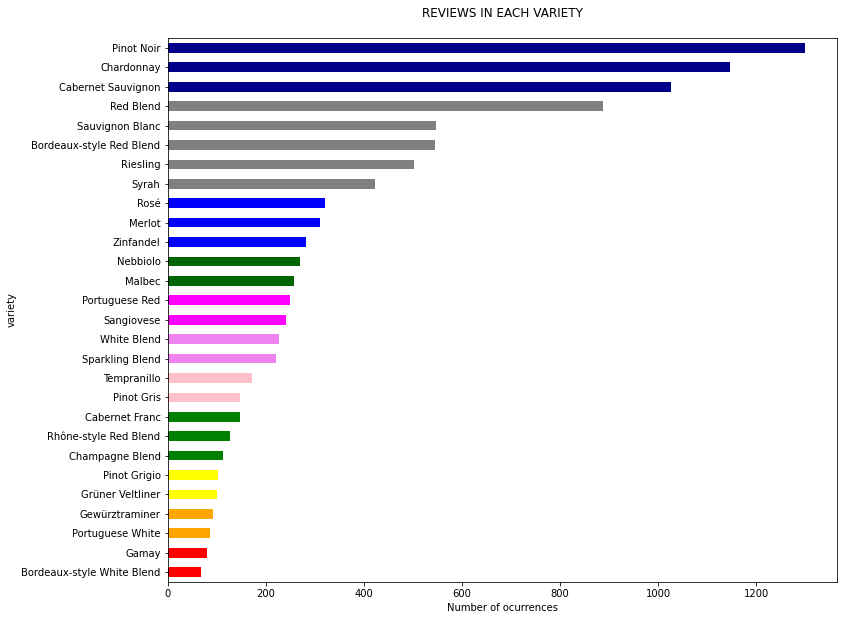

In [13]:
fig = plt.figure(figsize=(12,10))
colors = ['red','red','orange','orange','yellow','yellow','green','green','green','pink','pink','violet','violet','magenta','magenta','darkgreen','darkgreen','blue','blue','blue','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('variety').review.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'REVIEWS IN EACH VARIETY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.review).toarray()

labels = df2.catid

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 10093 features (TF-IDF score of unigrams and bigrams)


In [15]:
N = 3
for variety, catid in sorted(catid2.items()):
  features_chi2 = chi2(features, labels == catid)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(variety))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bordeaux-style Red Blend:
  * Most Correlated Unigrams are: merlot, franc, bordeaux
  * Most Correlated Bigrams are: bordeaux style, cabernet sauvignon, cabernet franc

==> Bordeaux-style White Blend:
  * Most Correlated Unigrams are: herbaceous, botrytis, sémillon
  * Most Correlated Bigrams are: white bordeaux, fruits pears, blanc sémillon

==> Cabernet Franc:
  * Most Correlated Unigrams are: loire, limits, franc
  * Most Correlated Bigrams are: brings notes, cabernet franc, cab franc

==> Cabernet Sauvignon:
  * Most Correlated Unigrams are: cassis, cabernet, cab
  * Most Correlated Bigrams are: black currants, cedar flavors, 100 cabernet

==> Champagne Blend:
  * Most Correlated Unigrams are: dosage, nonvintage, champagne
  * Most Correlated Bigrams are: lively mousse, pinot meunier, balanced soft

==> Chardonnay:
  * Most Correlated Unigrams are: chard, buttered, chardonnay
  * Most Correlated Bigrams are: tropical fruit, yellow fruits, buttered toast

==> Gamay:
  * Most Co

In [16]:
df2.head()

,variety,review,price,points,catid
29578,Syrah,"Ripe, loamy cherry and blackberry aromas are m...",42.0,90,0
3498,Portuguese White,A rich wine with six months in oak that gives ...,19.0,91,1
61256,Chardonnay,"Fermented and aged in French oak, this is a fo...",35.0,89,2
200,Sparkling Blend,"Smells a bit pickled and green at first, with ...",9.0,83,3
32151,Pinot Noir,The Bertins Premier Cru vineyard is on the sou...,104.0,94,4


In [0]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=500),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [18]:
entries

[('RandomForestClassifier', 0, 0.3275),
 ('RandomForestClassifier', 1, 0.301),
 ('RandomForestClassifier', 2, 0.329),
 ('RandomForestClassifier', 3, 0.343),
 ('RandomForestClassifier', 4, 0.3185),
 ('LinearSVC', 0, 0.6325),
 ('LinearSVC', 1, 0.6225),
 ('LinearSVC', 2, 0.613),
 ('LinearSVC', 3, 0.6145),
 ('LinearSVC', 4, 0.629),
 ('MultinomialNB', 0, 0.4245),
 ('MultinomialNB', 1, 0.429),
 ('MultinomialNB', 2, 0.427),
 ('MultinomialNB', 3, 0.4285),
 ('MultinomialNB', 4, 0.4295),
 ('LogisticRegression', 0, 0.5685),
 ('LogisticRegression', 1, 0.565),
 ('LogisticRegression', 2, 0.573),
 ('LogisticRegression', 3, 0.561),
 ('LogisticRegression', 4, 0.5625)]

In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.6223,0.008607
LogisticRegression,0.5660,0.004835
MultinomialNB,0.4277,0.002019
RandomForestClassifier,0.3238,0.015470


In [0]:
import xgboost as xgb
dtrain = xgb.DMatrix(features, label=labels)
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 28}  # the number of classes that exist in this datset
num_round = 5  # the number of training iterations
cvresult = xgb.cv(param, dtrain, num_round,nfold=5)

In [0]:
cvresult1=cvresult.mean()

In [0]:

acc.loc["XG Boost"] = [cvresult1[2],cvresult1[3]]


In [23]:
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.62230,0.008607
LogisticRegression,0.56600,0.004835
MultinomialNB,0.42770,0.002019
RandomForestClassifier,0.32380,0.015470
XG Boost,0.50512,0.008256


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(1000, input_dim=10093, activation='relu'))
	model.add(Dense(28, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=500, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, features, labels, cv=kfold)

Using TensorFlow backend.


In [0]:
acc.loc['Artificial Neural Network']=[results.mean(),results.std()]

In [0]:
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.62230,0.008607
LogisticRegression,0.56600,0.004835
MultinomialNB,0.42770,0.002019
RandomForestClassifier,0.32380,0.015470
XG Boost,0.50512,0.008256
Artificial Neural Network,0.58260,0.003813


In [0]:
test= pd.read_csv('/gdrive/My Drive/Data/test.csv')

In [25]:
test.shape[0]

20665

In [0]:
test= test[pd.notnull(test['review_description'])]

In [27]:
features_test = tfidf.transform(test.review_description).toarray()
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features_test.shape))

Each of the 20665 complaints is represented by 10093 features (TF-IDF score of unigrams and bigrams)


In [0]:
model=LinearSVC()
model.fit(features,labels)
pred = model.predict(features_test)

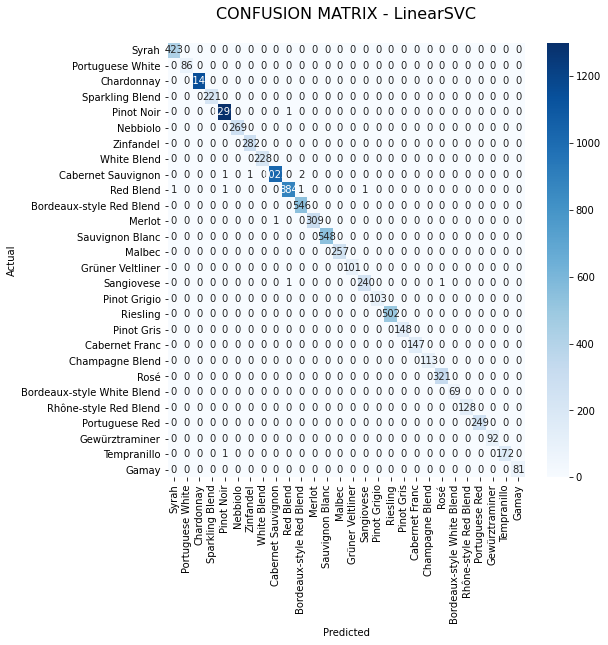

In [29]:
from sklearn.metrics import confusion_matrix
pred_train = model.predict(features)
conf_mat = confusion_matrix(labels, pred_train)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=catid_df2.variety.values,
            yticklabels=catid_df2.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [0]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [0]:
prednew=[]
for i in range(0,20665):
  prednew.append(idcat2[pred[i]])

In [0]:
test['variety']=prednew

In [0]:
with open('/gdrive/My Drive/Data/pred.csv', 'w') as f:
  test.to_csv(f,index=False)

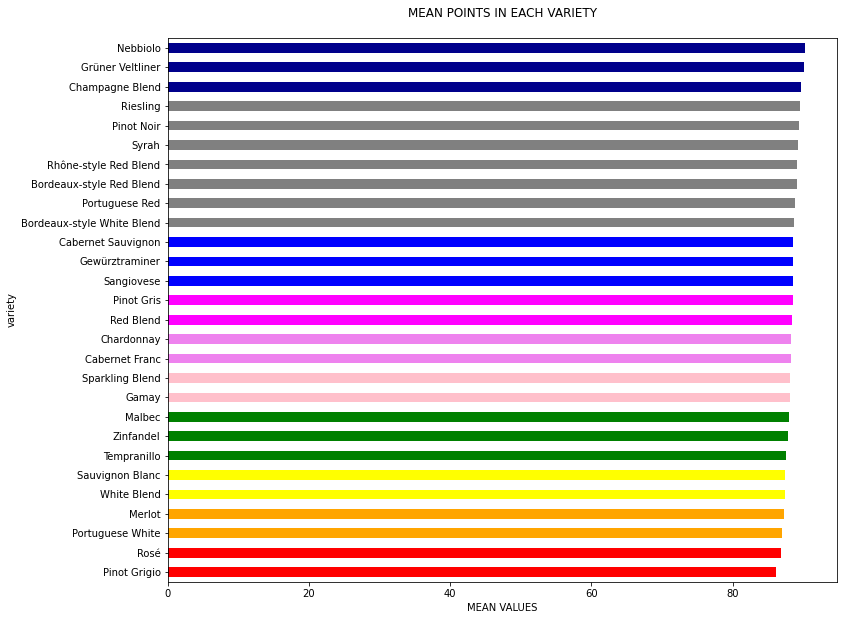

In [0]:
train1= train[pd.notnull(train['price'])]
train1= train[pd.notnull(train['points'])]
fig = plt.figure(figsize=(12,10))
colors = ['red','red','orange','orange','yellow','yellow','green','green','green','pink','pink','violet','violet','magenta','magenta','blue','blue','blue','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
train1.groupby('variety').points.mean().sort_values().plot.barh(
    ylim=0, color=colors, title= 'MEAN POINTS IN EACH VARIETY\n')
plt.xlabel('MEAN VALUES', fontsize = 10);


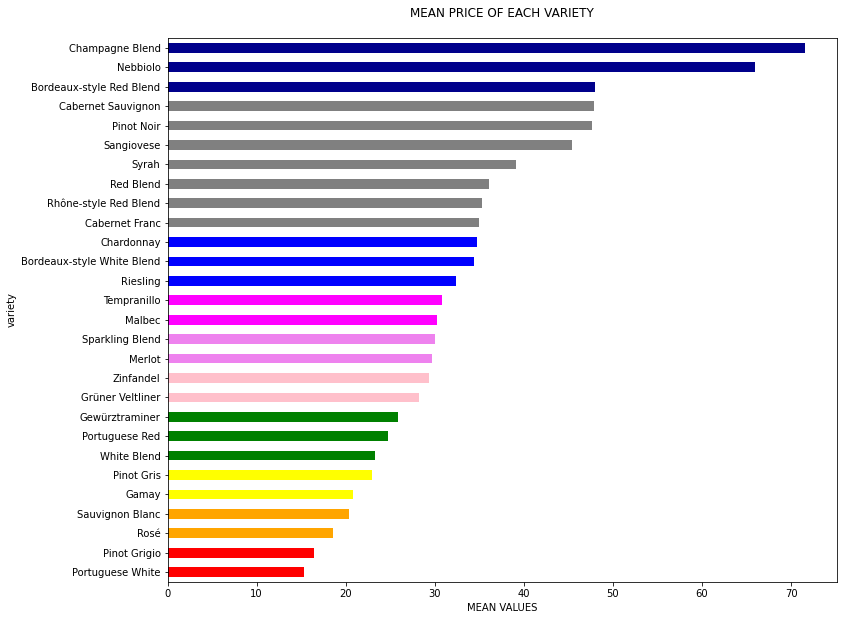

In [0]:
train1= train[pd.notnull(train['price'])]
train1= train[pd.notnull(train['points'])]
fig = plt.figure(figsize=(12,10))
colors = ['red','red','orange','orange','yellow','yellow','green','green','green','pink','pink','violet','violet','magenta','magenta','blue','blue','blue','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
train1.groupby('variety').price.mean().sort_values().plot.barh(
    ylim=0, color=colors, title= 'MEAN PRICE OF EACH VARIETY\n')
plt.xlabel('MEAN VALUES', fontsize = 10);


In [0]:
train1= train1[pd.notnull(train['country'])]
train1['country'].unique().shape[0]


38

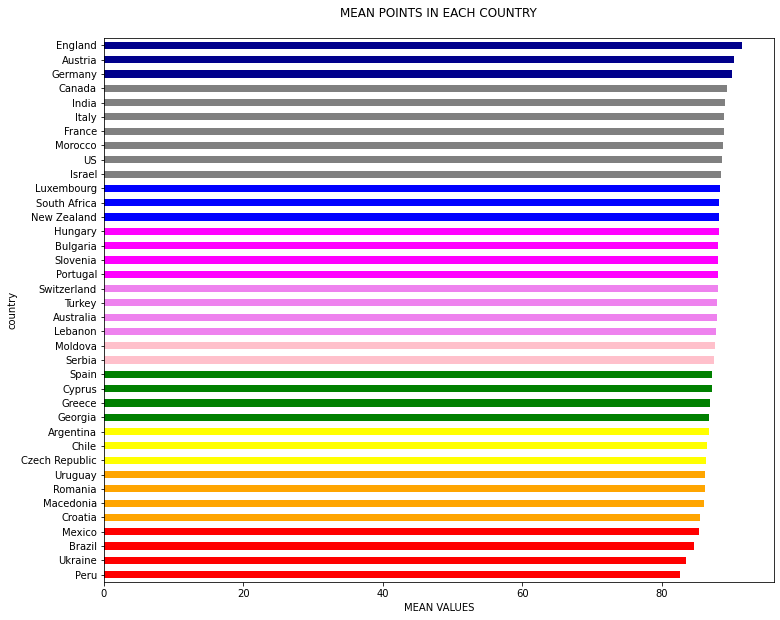

In [0]:


fig = plt.figure(figsize=(12,10))
colors = ['red','red','red','red','orange','orange','orange','orange','yellow','yellow','yellow','green','green','green','green','pink','pink','violet','violet','violet','violet','magenta','magenta','magenta','magenta','blue','blue','blue','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
train1.groupby('country').points.mean().sort_values().plot.barh(
    ylim=0, color=colors, title= 'MEAN POINTS IN EACH COUNTRY\n')
plt.xlabel('MEAN VALUES', fontsize = 10);


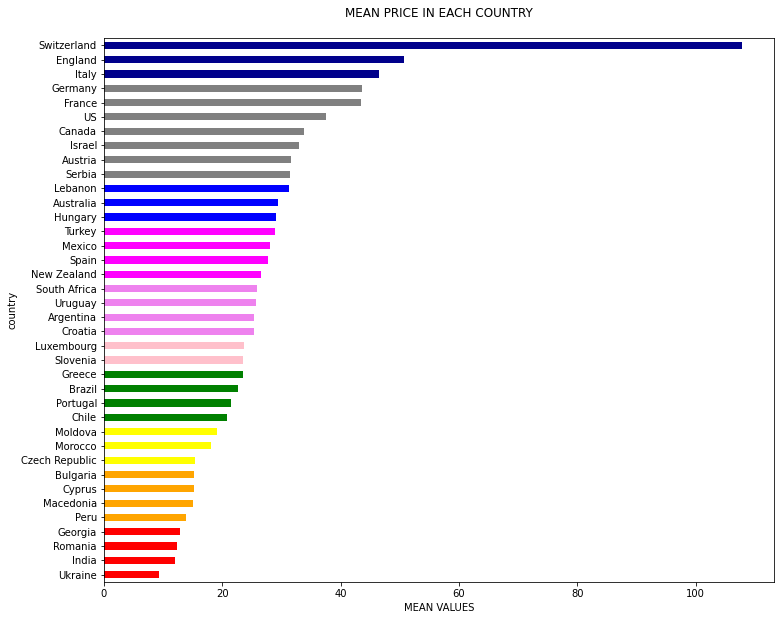

In [0]:
fig = plt.figure(figsize=(12,10))
colors = ['red','red','red','red','orange','orange','orange','orange','yellow','yellow','yellow','green','green','green','green','pink','pink','violet','violet','violet','violet','magenta','magenta','magenta','magenta','blue','blue','blue','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
train1.groupby('country').price.mean().sort_values().plot.barh(
    ylim=0, color=colors, title= 'MEAN PRICE IN EACH COUNTRY\n')
plt.xlabel('MEAN VALUES', fontsize = 10);

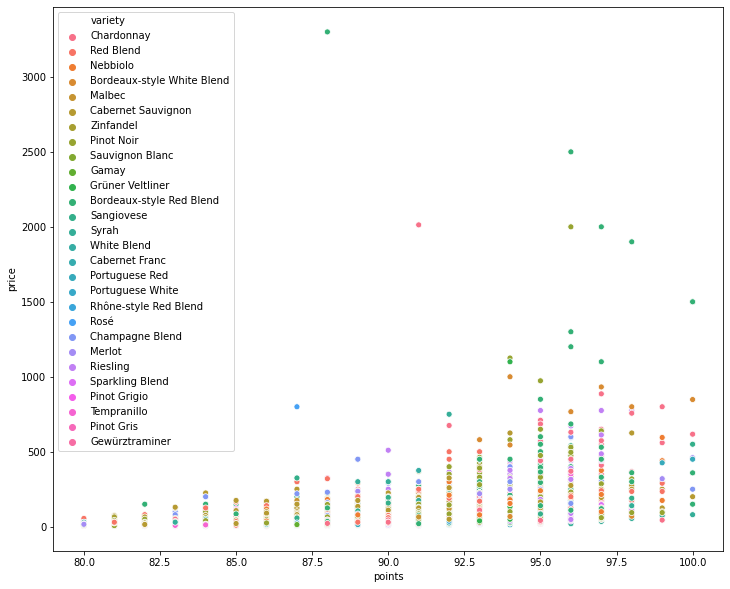

In [0]:
import seaborn as sns
plt.figure(figsize=(12,10))

sns.scatterplot(x=train1['points'], y=train1['price'], hue=train1['variety'])

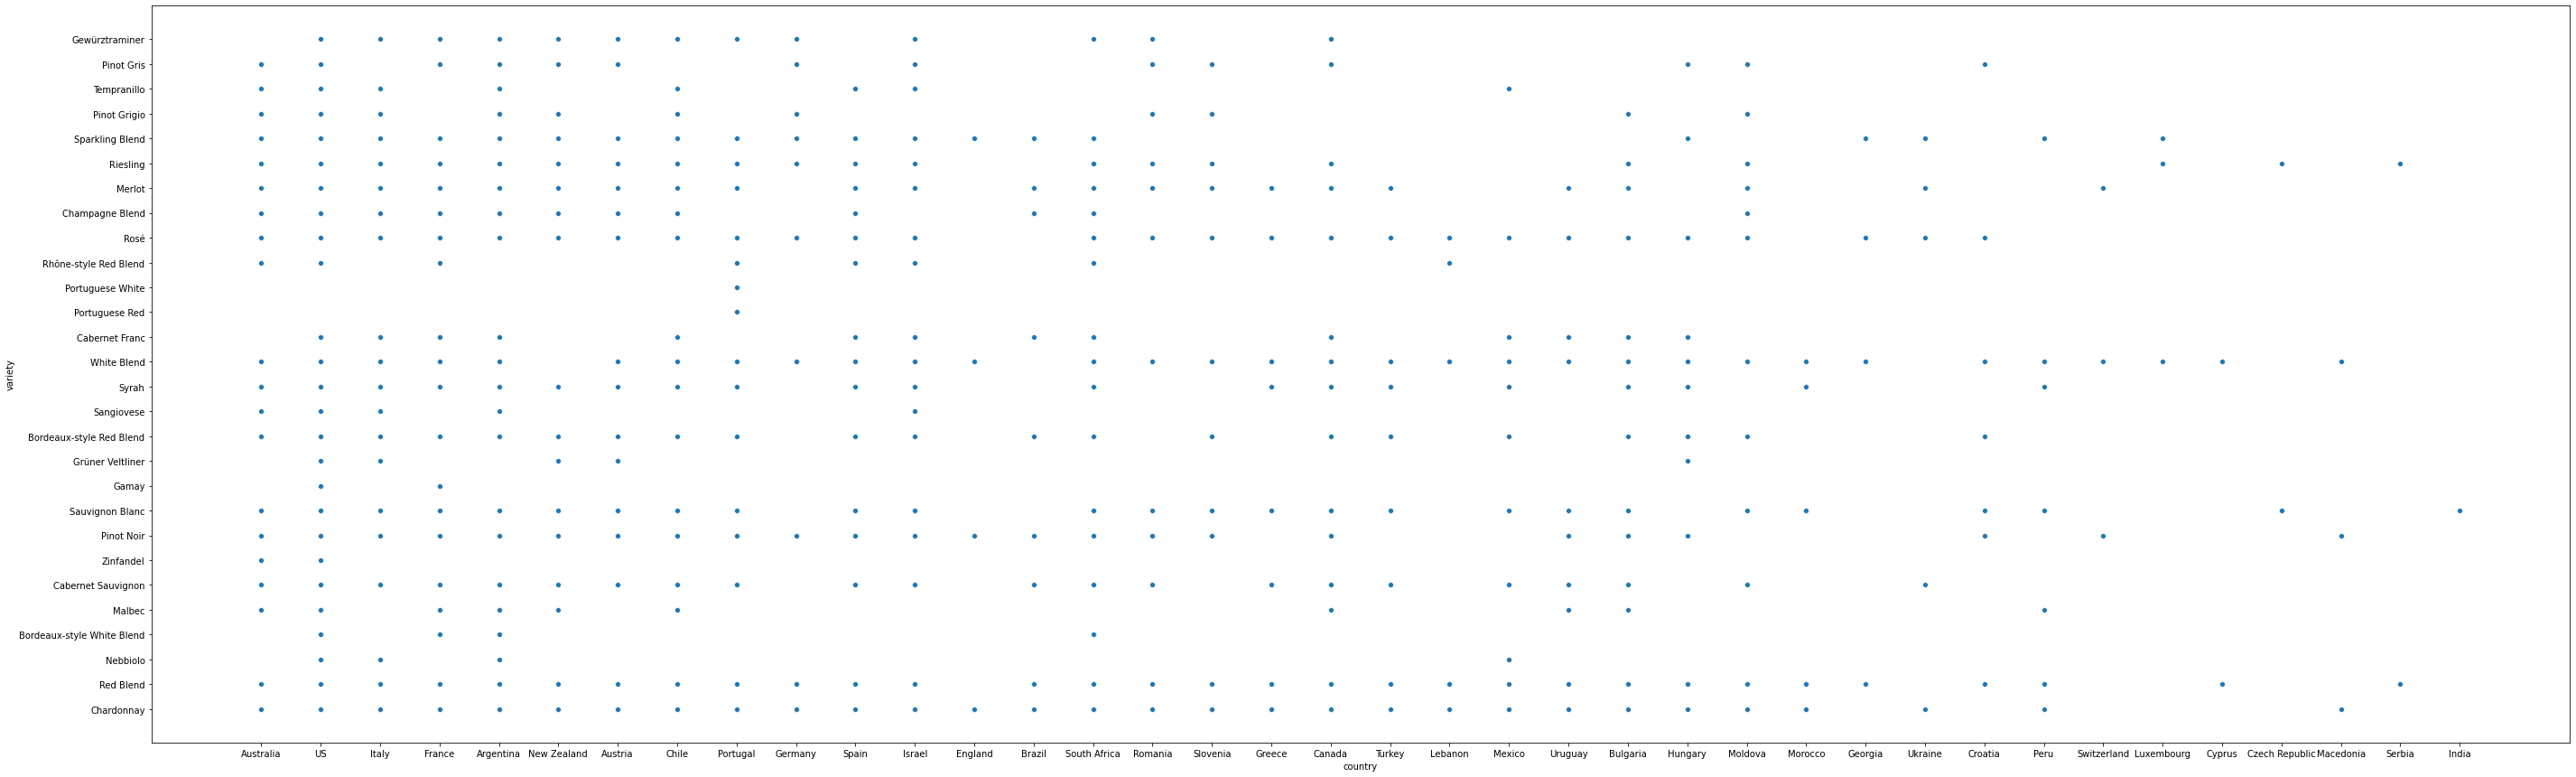

In [0]:
import seaborn as sns
plt.figure(figsize=(48,15))

sns.scatterplot(x=train1['country'], y=train1['variety'])

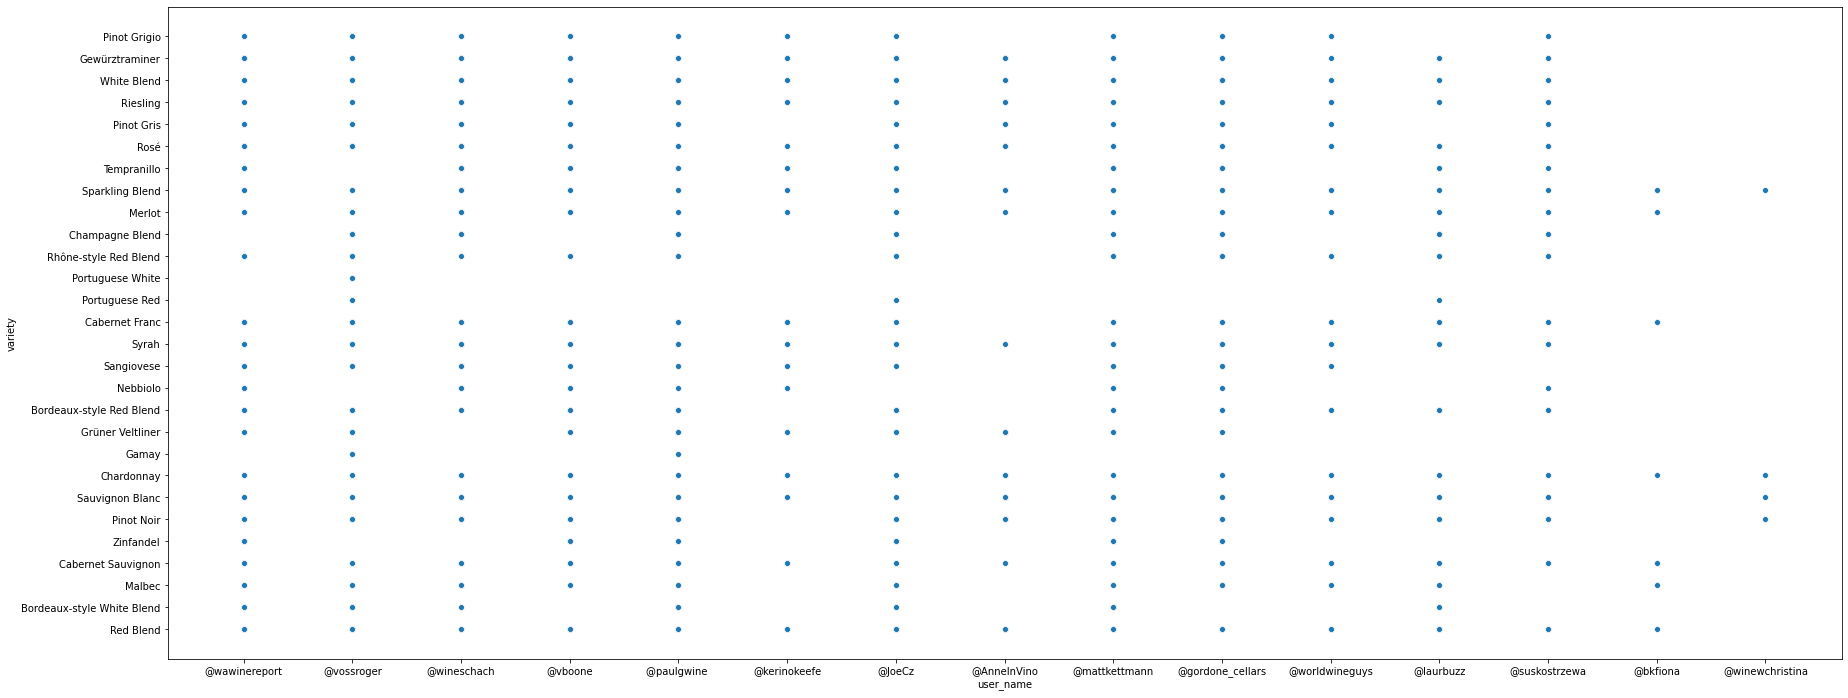

In [0]:

plt.figure(figsize=(30,12))

sns.scatterplot(x=train1['user_name'], y=train1['variety'])

13786